In [17]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Time-series forecasting with Deep Learning

#### Instalation `pip install mpld3 pydot`
`mpld3` enables zooming of the matplotlib and interactive data visualizations on Jupyter notebook.

In [18]:
import numpy as np
import pandas as pd
# import pandas_datareader as pdr
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

# import mpld3
# mpld3.enable_notebook()

In [19]:
# get all targets y from a TimeseriesGenerator instance.
def get_y_from_generator(gen):
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1)) # Reshape y into a 2D array
    print(y.shape)
    return y


## Load data

Let's generate and visualize a synthetic time series dataset consisting of a combination of `sine` and `cosine` waves with added noise

(500, 1)


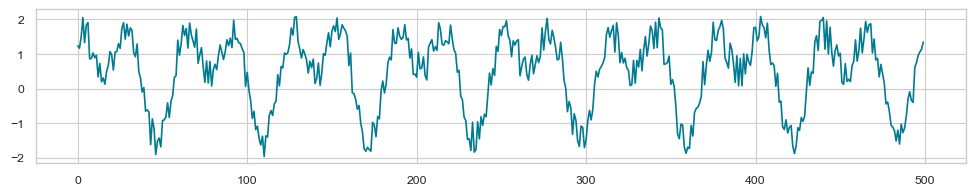

In [20]:
n = 500
x = np.arange(0, n, 1) 
# Create a time series signal with a combination of sine and cosine waves
y = np.sin(16*np.pi*x/n) + np.cos(32*np.pi*x/n)
# Add random noise to simulate real-world data variations
noisy = np.random.rand(n)
y = y + noisy
data_org = y.reshape(-1, 1)

data = data_org
print(data.shape)
plt.rcParams["figure.figsize"] = (12,2)
plt.plot(data)

## Data transformation

**The Augmented Dickey-Fuller (ADF)** test is a `statistical test` used to determine whether a time series is stationary (it has a constant mean and variance over time). Non-stationary data can lead to inaccurate predictions. A low p-value (<0.05) means the data is stationary, while a high value suggests it needs transformation before applying predictive models.

**Seasonal-Trend Decomposition (STL)** is a technique used to separate a time series into its trend, seasonality, and residual components. Removing the seasonal component can improve forecasting performance. In this case, STL helps extract the trend from our noisy time series, focus on the underlying long-term pattern making it easier to analyze and model 

STL separates time series into:
 - trend (long-term movement)
 - seasonality (repeating patterns)
 - residual (random noise)

	1. ADF :  -4.210873682274771
	2. P-Value :  0.0006315242037016598
	3. Num Of Lags :  16


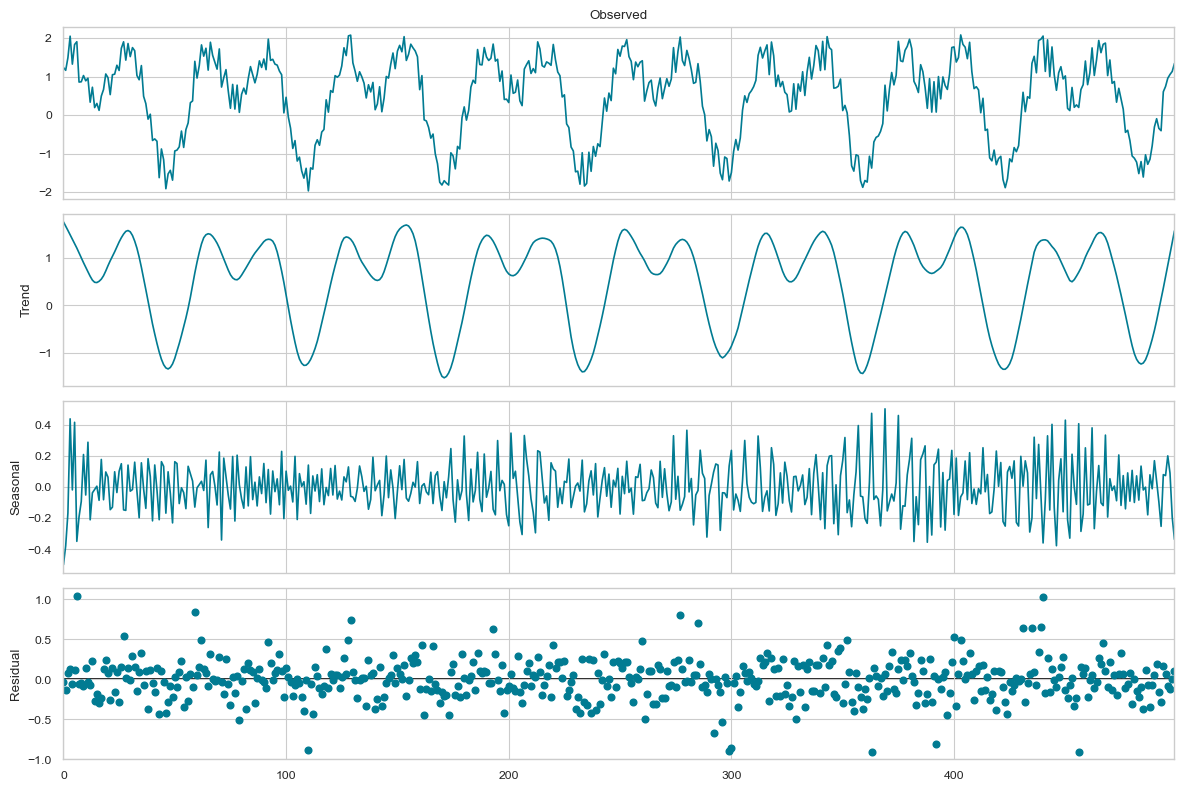

In [21]:
dftest = adfuller(data, autolag = 'AIC') # Perform ADF test to check for stationarity
print("\t1. ADF : ",dftest[0])
print("\t2. P-Value : ", dftest[1])
print("\t3. Num Of Lags : ", dftest[2])
          
result = STL(data, period=6, robust = True).fit() # Apply STL decomposition
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()
data_cleaned = result.trend.reshape(-1, 1)  # Extract the trend and reshape to (n,1)

## Data normalization

We normalize the data to improve the stability and efficiency of model training, especially for **LSTMs**, which perform better with values in a `small range`.Additionally, normalization prevents large values from dominating smaller ones, ensuring the model treats all input data fairly. 

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale data between 0 and 1
data_trans = scaler.fit_transform(data_cleaned)

## Data splitting and time-series generator

Let`s split the dataset into 80% training and 20% testing

`TimeseriesGenerator` helps prepare sequential time-series data for LSTM models

In [23]:
train_size = int(len(data_trans) * 0.80)
test_size = len(data_trans) - train_size

train, test = data_trans[0:train_size,:], data_trans[train_size:len(data_trans),:]

look_back = 10 #determines how many past time steps are used to predict the next value
train_data_gen = TimeseriesGenerator(train, 
                                     train,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=1
                                    )
test_data_gen = TimeseriesGenerator(test, 
                                    test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1
                                   )

## Training

Defining a simple LSTM (Long Short-Term Memory) model for time-series prediction

In [24]:
# model
x = Input(shape=(look_back, 1))  # Input layer
h = LSTM(units=5)(x)   # LSTM layer with 5 memory units
y = Dense(units=1, activation='sigmoid')(h)  # Output layer with 1 neuron, sigmoid activation

model = Model(inputs=x, outputs=y) # Create the Keras model
print(model.summary())

# compile model
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
model.fit(train_data_gen, epochs=20, shuffle=True)

Epoch 1/20
 51/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0708 - mae: 0.2362 - mse: 0.0708

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0725 - mae: 0.2363 - mse: 0.0725
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0466 - mae: 0.1702 - mse: 0.0466
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0296 - mae: 0.1406 - mse: 0.0296
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - mae: 0.0927 - mse: 0.0122
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0640 - mse: 0.0059
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - mae: 0.0601 - mse: 0.0050
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - mae: 0.0483 - mse: 0.0035
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mae: 0.0375 - mse: 0.0021
Epoch 9/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - mae: 0.0303 - mse: 0.0014
Epoch 10/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - mae: 0.0271 - mse: 0.0012
Epoch 11/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

Evaluating the trained LSTM model on the test dataset to measure its performance on unseen data

In [26]:
model.evaluate(test_data_gen)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8036e-04 - mae: 0.0164 - mse: 3.8036e-04 


[0.0004496995825320482, 0.0004496995825320482, 0.01754806376993656]

In [27]:
trainPredict = model.predict(train_data_gen)
print(trainPredict.shape)
testPredict = model.predict(test_data_gen)
print(testPredict.shape)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(390, 1)
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(90, 1)


## Invert transformation

We obtained the predicted values; however, since the model was trained on scaled data, we need to reverse the MinMax scaling to restore the data to its original scale for accurate evaluation and real-world interpretation.

In [28]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

Retrieving the actual target values (Y) from the TimeseriesGenerator to compare against predicted values

In [29]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(390, 1)
(90, 1)


Since the actual target values (Y) were also normalized, we reverse the scaling to get them back to their original form

In [30]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

## Model evaluation

**RMSE (Root Mean Squared Error)** is a standard metric for regression tasks, especially in time-series forecasting.

A low and similar `RMSE` for both training and testing sets indicates a well-trained and generalized model

In [31]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


## Plotting

Plotting the actual time-series data along with the model's predictions

The model's predictions (red) follow the actual test values (orange) closely, which indicates good forecasting performance.

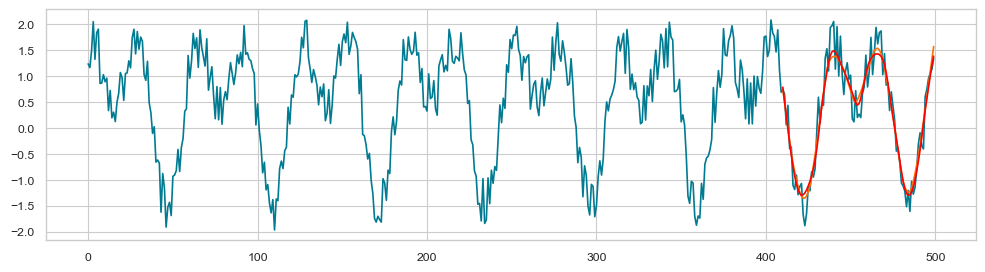

In [32]:
begin = train_size + look_back
end = begin + len(testPredict)

testYPlot = np.empty_like(data_org)
testYPlot[:, :] = np.nan # Fill it with NaNs so that only the test values appear
testYPlot[begin:end, :] = testY # Assign actual test values in the correct time rang

testPredictPlot = np.empty_like(data_org)
testPredictPlot[:, :] = np.nan # Fill it with NaNs so that only predictions appear
testPredictPlot[begin:end, :] = testPredict # Assign predicted values in the test range

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(data_org)
plt.plot(testYPlot)
plt.plot(testPredictPlot)
plt.show()